# Data Diri

Nama: Sahrial Ihsani Ishak

Asal: Bengkulu

# Code



Dataset: https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

Face expression Recognition with CNN

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sahrialihsaniishak","key":"1cd8c1d5abed5608434908e6b1d8d093"}'}

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!ls

 90% 108M/121M [00:01<00:00, 71.7MB/s] 
100% 121M/121M [00:01<00:00, 104MB/s] 
face-expression-recognition-dataset.zip  kaggle.json  sample_data


In [5]:
#Import Library
import zipfile
import os
import shutil
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Model,Sequential
from keras.optimizers import Adam

In [6]:
# Ekstraksi pada file zip sebelumnya
local_zip = '/content/face-expression-recognition-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
#Delete beberapa folder train yang tidak dibutuhkan
!rm -rf '/content/images/train/angry'
!rm -rf '/content/images/train/neutral'
!rm -rf '/content/images/train/disgust'
!rm -rf '/content/images/train/fear'
!rm -rf '/content/images/train/surprise'

#Delete beberapa folder validation yang tidak dibutuhkan
!rm -rf '/content/images/validation/angry'
!rm -rf '/content/images/validation/neutral'
!rm -rf '/content/images/validation/disgust'
!rm -rf '/content/images/validation/fear'
!rm -rf '/content/images/validation/surprise'

In [8]:
train_folder = '/content/images/train'
validation_folder = '/content/images/validation'

In [9]:
#Augmentasi dan generate gambar
train_datagen = ImageDataGenerator(rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [10]:
#Preprocessing data with generator
train_generator = train_datagen.flow_from_directory(
        train_folder,  
        target_size=(48, 48), 
        batch_size=8,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        validation_folder, 
        target_size=(48, 48),  
        batch_size=8, 
        class_mode='binary')

Found 12102 images belonging to 2 classes.
Found 2964 images belonging to 2 classes.


In [11]:
#CNN Architecture Model sequentials (Maxpooling and convolutional layer), flatten to make single array
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# Sequential Model
model = Sequential()

# Conv 1
model.add(Conv2D(64,(3,3), input_shape=(48, 48,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 2
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 3
model.add(Conv2D(256,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 4
model.add(Conv2D(512,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())

# Fully connected layer 1
model.add(Dense(1024))
model.add(Activation('relu'))

# Fully connected layer 2
model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
#Callback untuk mencegah overfitting dengan menghentikan training, apabila telah terpenuhi
class reduceOverfitting(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93 ):
      print("\nStopped! Akurasi training dan validasi sudah mencapai 93% dan 93%")
      self.model.stop_training = True
stop = reduceOverfitting()

In [13]:
#see the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         2

In [14]:
#train our model with callback to reduce overfitting 
trainmodel = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = validation_generator.n//validation_generator.batch_size,
    verbose =2,       
      callbacks=[stop] 
)

Epoch 1/30
1512/1512 - 62s - loss: 0.6447 - accuracy: 0.6294 - val_loss: 0.5788 - val_accuracy: 0.6878
Epoch 2/30
1512/1512 - 18s - loss: 0.4685 - accuracy: 0.7676 - val_loss: 0.3997 - val_accuracy: 0.8064
Epoch 3/30
1512/1512 - 17s - loss: 0.3882 - accuracy: 0.8177 - val_loss: 0.3521 - val_accuracy: 0.8446
Epoch 4/30
1512/1512 - 18s - loss: 0.3500 - accuracy: 0.8398 - val_loss: 0.3320 - val_accuracy: 0.8486
Epoch 5/30
1512/1512 - 17s - loss: 0.3218 - accuracy: 0.8557 - val_loss: 0.3135 - val_accuracy: 0.8618
Epoch 6/30
1512/1512 - 18s - loss: 0.2988 - accuracy: 0.8675 - val_loss: 0.3223 - val_accuracy: 0.8561
Epoch 7/30
1512/1512 - 17s - loss: 0.2758 - accuracy: 0.8811 - val_loss: 0.2954 - val_accuracy: 0.8699
Epoch 8/30
1512/1512 - 18s - loss: 0.2640 - accuracy: 0.8860 - val_loss: 0.2963 - val_accuracy: 0.8706
Epoch 9/30
1512/1512 - 17s - loss: 0.2495 - accuracy: 0.8955 - val_loss: 0.2781 - val_accuracy: 0.8821
Epoch 10/30
1512/1512 - 18s - loss: 0.2374 - accuracy: 0.9023 - val_loss:

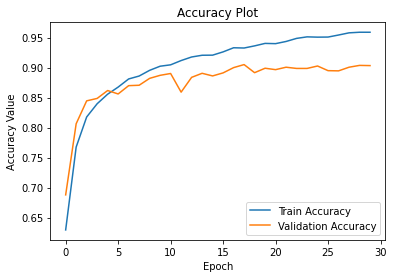

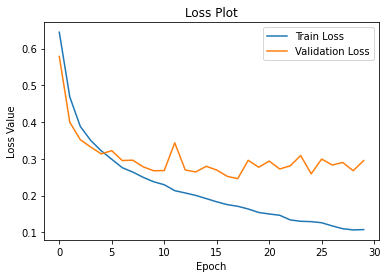

In [15]:
#Accuracy Plot
plt.plot(trainmodel.history['accuracy'], label='Train Accuracy')
plt.plot(trainmodel.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch') 
plt.legend(loc="lower right")
plt.show()
#Loss Plot
plt.plot(trainmodel.history['loss'], label='Train Loss')
plt.plot(trainmodel.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [16]:
#Convert to tf lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#save 
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9yrdasaq/assets
